In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import *
from random import seed
from scipy import stats
import seaborn as sns
import pingouin as pg
from sklearn.linear_model import LinearRegression, LassoCV, RidgeCV
import statsmodels.api as sm
from statsmodels.stats.api import anova_lm
from statsmodels.formula.api import ols
from statsmodels.regression import linear_model
from sklearn.metrics import explained_variance_score
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import train_test_split
%matplotlib inline

seed(888)
pd.set_option('display.max_columns', None)

# 1 Load validation set

In [2]:
# load data from pickle and convert to dataframe
brain_test = pd.read_pickle("brain_test_validate.pkl")
brain_train = pd.read_pickle("2_brain_train.pkl")
main_test = pd.read_pickle("main_test_validate.pkl")
brain_test = pd.DataFrame(brain_test)
brain_train = pd.DataFrame(brain_train)
main_test = pd.DataFrame(main_test)

# 2 Preprocessing of validation set

## 2.1 Physical activity preprocessing

People excluded due to wear time < 8000 minutes: 1147
People with data quality good wear time: Yes    8411
No        0
Name: data_quality_good_wear_time_f90015_0_0, dtype: int64
People with data quality good calibration: Yes    8411
No        0
Name: data_quality_good_calibration_f90016_0_0, dtype: int64


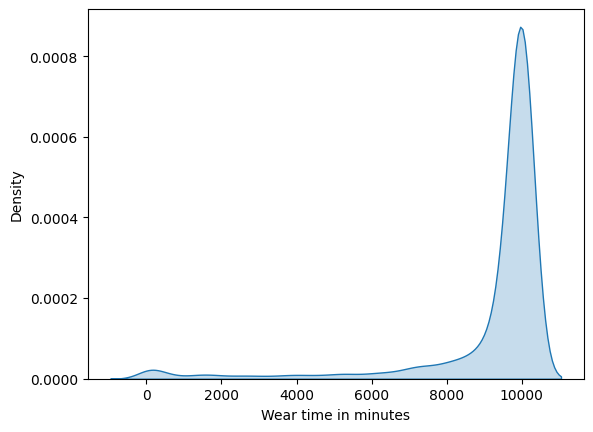

In [3]:
# get weartime duration in minutes (it's in days at default)
main_test["Wear time in minutes"] = main_test.iloc[:,16686]*1440
sns.kdeplot(data = main_test, x= 'Wear time in minutes', fill=True)

# exclude people with insufficient weartime weartime < 8000 minutes
wear_time_test = main_test[main_test["Wear time in minutes"]<8000].index
print("People excluded due to wear time < 8000 minutes:", len(wear_time_test))
brain_test = brain_test.drop(wear_time_test)
main_test = main_test.drop(wear_time_test)

# check wear time and data quality
print("People with data quality good wear time:", main_test.iloc[:,16650].value_counts())
print("People with data quality good calibration:", main_test.iloc[:,16651].value_counts())

(0.0, 0.01)

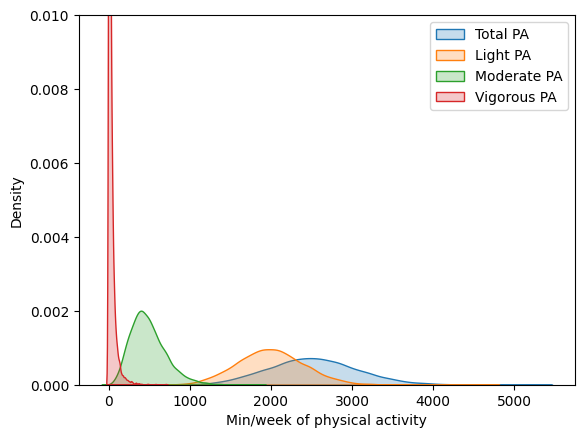

In [4]:
# distributions are cumulative -> substract ditributions from each other
# determine fraction of weartime spent doing light PA (between 30 and 125 milligravites)
light_PA = np.asarray(main_test.iloc[:,16763]-main_test.iloc[:,16748])
# get it in minutes / week
light_PA = light_PA * main_test["Wear time in minutes"]
main_test["Light PA"] = light_PA

# determine fraction of weartime spent doing moderate PA (between 125 and 400 milligravites)
moderate_PA = np.asarray(main_test.iloc[:,16774]-main_test.iloc[:,16763])
moderate_PA = moderate_PA * main_test["Wear time in minutes"]
main_test["Moderate PA"] = moderate_PA

# determine fraction of weartime spent doing vigorous PA (above 400 milligravites)
vigorous_PA = np.asarray(1-main_test.iloc[:,16774])
vigorous_PA = vigorous_PA * main_test["Wear time in minutes"]
main_test["Vigorous PA"] = vigorous_PA

# fraction of weartime for above 30 mg -> total summed light, moderate, and vigorous PA
total_PA = np.asarray(1-main_test.iloc[:,16748])
total_PA = total_PA * main_test["Wear time in minutes"]
main_test["Total PA"] = total_PA

# moderate + 2* vigorous PA -> weighten greater than moderate activity
main_test["MVPA"] = main_test["Moderate PA"] + main_test["Vigorous PA"]*2

## 2.2 BrainAge prediction for A2009 and All variables

In [5]:
nan_all_test = brain_test[brain_test.iloc[:,1:2544:2].isnull().any(axis=1)].index
nan_all_train = brain_train[brain_train.iloc[:,1:2544:2].isnull().any(axis=1)].index
main_test = main_test.drop(nan_all_test)
brain_test = brain_test.drop(nan_all_test)
brain_train = brain_train.drop(nan_all_train)

print("Number of people with missing brain values in train set:", len(nan_all_train))
print("Number of people with missing brain values in test set:", len(nan_all_test))

Number of people with missing brain values in train set: 42
Number of people with missing brain values in test set: 25


### 2.2.1 A2009

In [6]:
X_train = brain_train.iloc[:,1657:2544:2]
Y_train = brain_train.iloc[:,-1]
X_test = brain_test.iloc[:,1657:2544:2]
Y_test = brain_test.iloc[:,-1]

In [7]:
# set of alphas to try (=penalization)
alpha_parameters = np.power(10,np.linspace(start=-3, stop=5, num=100))

# standardize x-data
X_train_std = stats.zscore(X_train)
X_test_std = stats.zscore(X_test)

# Cross validation
# cross validation on training set only -> select training set
X_CV = X_train_std
Y_CV = Y_train
# randomly split data (only training no PA) into training and testing set
X_train_cv, X_test_cv, Y_train_cv, Y_test_cv = train_test_split(X_CV,Y_CV, random_state=8)
model = RidgeCV(alphas = alpha_parameters)
model.fit(X_train_cv,Y_train_cv)
y_pred_cv = model.predict(X_test_cv)
delta_cv = y_pred_cv - Y_test_cv
print("The MAE for cross-validation (Ridge):", mean_absolute_error(Y_test_cv,y_pred_cv))

The MAE for cross-validation (Ridge): 4.178356335982309


In [8]:
# BrainAge model for testing data
# model trained on training tested on test
# model initialization - options to use Lasso, Ridge or SVM

#model_Lasso = LassoCV(alphas = alpha_parameters, max_iter=100000)
model_Ridge = RidgeCV(alphas = alpha_parameters)
#model_SVR = SVR(kernel = 'rbf')

# train model on training data
#model_Lasso.fit(X_train_std,Y_train)
model_Ridge.fit(X_train_std,Y_train)
#model_SVR.fit(X_train_std,Y_train)

# get predicted values for test set
#y_pred_Lasso = model_Lasso.predict(X_test_std)
y_pred_Ridge = model_Ridge.predict(X_test_std)
#y_pred_SVR = model_SVR.predict(X_test_std)

# calculate brain age gap
#brain_age_delta_Lasso = y_pred_Lasso-Y_test
brain_age_delta_Ridge = y_pred_Ridge-Y_test
#brain_age_delta_SVR = y_pred_SVR-Y_test

# get mean absolute error (MAE)
#print("The MAE for testing set using Lasso:", mean_absolute_error(Y_test,y_pred_Lasso))
print("The MAE for testing set using Ridge:", mean_absolute_error(Y_test,y_pred_Ridge))
#print("The MAE for testing set using SVR:", mean_absolute_error(Y_test,y_pred_SVR))

#plot figure with x: actual age Y: predicted age, and a line with slope 1 for reference
# plt.figure()
# plt.scatter(Y_test, y_pred_Ridge, alpha=0.5, s=10)
# plt.axline((60,60), slope=1, color='r')
# plt.xticks(range(40,90,5))
# plt.yticks(range(40,90,5))
# plt.ylabel('Predicted Age', fontsize = 15)
# plt.xlabel('Age', fontsize = 15)
# plt.show()

# plt.figure()
# plt.scatter(Y_test,brain_age_delta_Ridge, alpha=0.5, s=10)
# plt.axline((65,0), slope=-0.69, color="r")
# plt.axline((60,0),slope=0, color = "g")
# plt.ylabel("Brain Age Delta", fontsize = 15)
# plt.xlabel("Age", fontsize = 15)
# plt.show()


The MAE for testing set using Ridge: 4.243659293588293


In [9]:
# reformat cross validation data for regression model
y_pred_cv = np.asarray(y_pred_cv)
y_pred_cv = np.reshape(y_pred_cv, (-1,1))
Y_test_cv = np.asarray(Y_test_cv)
Y_test_cv = np.reshape(Y_test_cv, (-1,1))

# now using correction from the R code that's online from Cole
reg = LinearRegression().fit(Y_test_cv, y_pred_cv)
coef = float(reg.coef_)
intercept = float(reg.intercept_)
print("Coefficient and Intercept:", coef, intercept)

# correction by cole
function = lambda t: (t-intercept)/coef
vfunc = np.vectorize(function)
corr_brainage_1 = vfunc(y_pred_Ridge)
corr_brainage_delta_1 = corr_brainage_1-Y_test


# plt.figure()
# plt.scatter(Y_test, corr_brainage_1, alpha=0.5, s=10)
# plt.axline((65,65), slope=coef, color="g")
# plt.ylabel("Brain Age Corrected", fontsize = 15)
# plt.axline((60,60), slope=1, color='r')
# plt.xlabel("Age", fontsize = 15)
# plt.xticks(range(40,90,5))
# plt.yticks(range(25,110,5))
# plt.show()

# plt.figure()
# plt.scatter(Y_test, corr_brainage_delta_1, alpha=0.5, s=10)
# plt.axline((60,0),slope=0, color = "g")
# plt.ylabel("Brain Age Delta Corrected", fontsize = 15)
# plt.xlabel("Age", fontsize = 15)
# plt.show()

Coefficient and Intercept: 0.5394718243976903 29.658905248225935


### 2.2.2 All Variables

In [10]:
X_train = brain_train.iloc[:,1:2544:2]
Y_train = brain_train.iloc[:,-1]
X_test = brain_test.iloc[:,1:2544:2]
Y_test = brain_test.iloc[:,-1]

# standardize x-data
X_train_std = stats.zscore(X_train)
X_test_std = stats.zscore(X_test)
#print(X_train_std)

# Cross validation
# cross validation on training set only -> select training set
X_CV = X_train_std
Y_CV = Y_train
# randomly split data (only training no PA) into training and testing set
X_train_cv, X_test_cv, Y_train_cv, Y_test_cv = train_test_split(X_CV,Y_CV, random_state=8)
model = RidgeCV(alphas = alpha_parameters)
model.fit(X_train_cv,Y_train_cv)
y_pred_cv = model.predict(X_test_cv)
delta_cv = y_pred_cv - Y_test_cv
print("The MAE for cross-validation (Ridge):", mean_absolute_error(Y_test_cv,y_pred_cv))

#model_Lasso = LassoCV(alphas = alpha_parameters, max_iter=100000, tol=1e-2)
model_Ridge = RidgeCV(alphas = alpha_parameters)
#model_SVR = SVR(kernel = 'rbf')

# train model on training data
#model_Lasso.fit(X_train_std,Y_train)
model_Ridge.fit(X_train_std,Y_train)
#model_SVR.fit(X_train_std,Y_train)


coeff = np.asarray(abs(model_Ridge.coef_))
top_10_coefficients = np.argsort(coeff)[-10:]
print(X_train_std.iloc[:,top_10_coefficients].columns)
print(coeff[top_10_coefficients])

# get predicted values for test set
#y_pred_Lasso = model_Lasso.predict(X_test_std)
y_pred_Ridge = model_Ridge.predict(X_test_std)
#y_pred_SVR = model_SVR.predict(X_test_std)

# calculate brain age gap
#brain_age_delta_Lasso = y_pred_Lasso-Y_test
brain_age_delta_Ridge = y_pred_Ridge-Y_test
#brain_age_delta_SVR = y_pred_SVR-Y_test

# # get mean absolute error (MAE)
# print("The MAE for testing set using Lasso:", mean_absolute_error(Y_test,y_pred_Lasso))
# print("The MAE for testing set using Ridge:", mean_absolute_error(Y_test,y_pred_Ridge))
# print("The MAE for testing set using SVR:", mean_absolute_error(Y_test,y_pred_SVR))

# print("The Spearman r for Ridge vs Lasso:", stats.spearmanr(brain_age_delta_Ridge, brain_age_delta_Lasso))
# print("The Spearman r for Ridge vs SVR:", stats.spearmanr(brain_age_delta_Ridge, brain_age_delta_SVR))
# print("The Spearman r for SVR vs Lasso:", stats.spearmanr(brain_age_delta_SVR, brain_age_delta_Lasso))



# plt.figure()
# plt.scatter(Y_test, y_pred_Ridge, alpha=0.5, s=10)
# plt.axline((60,60), slope=1, color='r')
# plt.xticks(range(40,90,5))
# plt.yticks(range(40,90,5))
# plt.ylabel('Predicted Age', fontsize = 15)
# plt.xlabel('Age', fontsize = 15)
# plt.show()

# plt.figure()
# plt.scatter(Y_test,brain_age_delta_Ridge, alpha=0.5, s=10)
# plt.axline((65,0), slope=-0.69, color="r")
# plt.axline((60,0),slope=0, color = "g")
# plt.ylabel("Brain Age Delta", fontsize = 15)
# plt.xlabel("Age", fontsize = 15)
# plt.show()

The MAE for cross-validation (Ridge): 3.0647491156733095
Index(['volume_of_vlp_left_hemisphere_f26686_2_0',
       'mean_intensity_of_3rdventricle_whole_brain_f26501_2_0',
       'mean_intensity_of_accumbensarea_left_hemisphere_f26548_2_0',
       'mean_intensity_of_caudate_left_hemisphere_f26543_2_0',
       'volume_of_midbrain_whole_brain_f26719_2_0',
       'greywhite_contrast_in_inferiorparietal_right_hemisphere_f27031_2_0',
       'greywhite_contrast_in_precuneus_left_hemisphere_f27013_2_0',
       'volume_of_wholebrainstem_whole_brain_f26720_2_0',
       'volume_of_ventraldc_right_hemisphere_f26596_2_0',
       'volume_of_pons_whole_brain_f26717_2_0'],
      dtype='object')
[0.6416308  0.64657282 0.64898987 0.64951277 0.72717357 0.76849623
 0.79190702 0.87692071 0.8917615  1.18980925]


In [11]:
# reformat cross validation data for regression model
y_pred_cv = np.asarray(y_pred_cv)
y_pred_cv = np.reshape(y_pred_cv, (-1,1))
Y_test_cv = np.asarray(Y_test_cv)
Y_test_cv = np.reshape(Y_test_cv, (-1,1))

# now using correction from the R code that's online from Cole
reg = LinearRegression().fit(Y_test_cv, y_pred_cv)
coef = float(reg.coef_)
intercept = float(reg.intercept_)
print("Coefficient and Intercept:", coef, intercept)

# correction by cole
function = lambda t: (t-intercept)/coef
vfunc = np.vectorize(function)
corr_brainage_4 = vfunc(y_pred_Ridge)
corr_brainage_delta_4 = corr_brainage_4-Y_test

print("The MAE for testing set corrected:", mean_absolute_error(Y_test,corr_brainage_4))

# plt.figure()
# plt.scatter(Y_test, corr_brainage_4, alpha=0.5, s=10)
# plt.ylabel("Brain Age Corrected", fontsize = 15)
# plt.axline((60,60), slope=1, color='r')
# plt.xlabel("Age", fontsize = 15)
# plt.xticks(range(40,90,5))
# plt.yticks(range(25,110,5))
# plt.show()

# plt.figure()
# plt.scatter(Y_test, corr_brainage_delta_4, alpha=0.5, s=10)
# plt.axline((60,0),slope=0, color = "g")
# plt.ylabel("Brain Age Delta Corrected", fontsize = 15)
# plt.xlabel("Age", fontsize = 15)
# plt.show()

Coefficient and Intercept: 0.7473056979712567 16.184077044061304
The MAE for testing set corrected: 3.6252121028038413


### 2.2.3 Add BrainAge Deltas to Dataframe

In [12]:
main_test["BADA2009"] = corr_brainage_delta_1
main_test["BADAll"] = corr_brainage_delta_4

## 2.3 Variable Selection

In [13]:
# same for full dataset without exclusions
main_test_crop = []
main_test_crop = pd.DataFrame(main_test_crop)

main_test_crop["Age"] = main_test["Age"]
main_test_crop["Gender"] = main_test.iloc[:,22]
main_test_crop["TPA"] = main_test["Total PA"]
main_test_crop["VPA"] = main_test["Vigorous PA"]
main_test_crop["MPA"] = main_test["Moderate PA"]
main_test_crop["MVPA"] = main_test["MVPA"]
main_test_crop["LPA"] = main_test["Light PA"]
main_test_crop["BMI"] = main_test.iloc[:,11580]
main_test_crop["ECGW"] = main_test.iloc[:, 5773]
main_test_crop["ECGHR"] = main_test.iloc[:, 5775]
main_test_crop["SRLPA"] = main_test.iloc[:,9989]
main_test_crop["SRMPA"] = main_test.iloc[:,9990]
main_test_crop["SRVPA"] = main_test.iloc[:,9991]
main_test_crop["FI"] = main_test.iloc[:,9052]
main_test_crop["HGL"] = main_test.iloc[:,64]
main_test_crop["HGR"] = main_test.iloc[:,68]
main_test_crop["IS"] = main_test['uk_biobank_assessment_centre_f54_2_0']
main_test_crop["Smoking"] = main_test.iloc[:,650]
main_test_crop["SES"] = main_test.iloc[:,456]
main_test_crop["HR"] = main_test.iloc[:,10079]
main_test_crop["JPA"] = main_test.iloc[:,507]
main_test_crop["DBP"] = main_test.iloc[:,1551]
main_test_crop["SBP"] = main_test.iloc[:,1559]
main_test_crop["WS"] = main_test.iloc[:,542]
main_test_crop["BADA2009"] = main_test["BADA2009"]
main_test_crop["BADAll"] = main_test["BADAll"]

main_test = main_test_crop

,Age,Gender,TPA,VPA,MPA,MVPA,LPA,BMI,ECGW,ECGHR,SRLPA,SRMPA,SRVPA,FI,HGL,HGR,IS,Smoking,SES,HR,JPA,DBP,SBP,WS,BADA2009,BADAll
24945,65.0,Male,1474.0416,18.0864,198.9504,235.1232,1257.0048,28.9,NaN,NaN,412.5,80.0,0.0,7.0,49.0,40.0,11025,No,-2.27794,NaN,Never/rarely,81.0,121.0,Brisk pace,10.787964,3.630621
34655,61.0,Male,2388.9600,50.4000,463.6800,564.4800,1874.8800,23.9,NaN,NaN,198.0,400.0,240.0,6.0,29.0,29.0,11025,No,-3.79876,55.0,Never/rarely,88.0,156.0,Brisk pace,0.744742,-0.623515
21099,55.0,Female,2246.7456,8.5104,272.3328,289.3536,1965.9024,44.5,NaN,NaN,1386.0,240.0,0.0,6.0,26.0,26.0,11025,No,-1.96244,NaN,Never/rarely,115.0,185.0,Steady average pace,-1.316817,2.478778
23431,67.0,Male,1854.7200,40.3200,413.2800,493.9200,1401.1200,25.1,NaN,NaN,396.0,320.0,960.0,6.0,36.0,19.0,11025,No,-1.88219,54.0,NaN,85.0,148.0,Brisk pace,1.253577,2.953462
24485,63.0,Male,2093.7024,9.3888,281.6640,300.4416,1802.6496,41.0,120.0,112.0,264.0,300.0,160.0,8.0,56.0,46.0,11025,No,-4.54202,60.0,Never/rarely,83.0,151.0,Brisk pace,6.638093,-1.099880


## 2.4 Recoding

In [14]:

# 1 = Cheadle;  2 = Reading;  3 = Newcastle;  4 = Bristol
main_test['IS'] = main_test['IS'].map({'11025': 1, '11026': 2,'11027': 3, '11028': 4})
main_test["Smoking"] = main_test["Smoking"].map({"No":0, "Only occasionally":1, "Yes, on most or all days":2})
main_test["Gender"] = main_test["Gender"].map({"Female":0, "Male":1})
main_test["Gender"] = main_test["Gender"].astype("int")
main_test["JPA"] = main_test["JPA"].map({"Never/rarely":0, "Sometimes":1, "Usually":2,"Always":3})
main_test["WS"] = main_test["WS"].map({"Slow pace":0, "Steady average pace":1, "Brisk pace":2})


main_test = main_test.rename(columns={"BADA2009": "BA"})

main_test = pd.DataFrame(main_test)

# 3 Basic distributions of validation set

## 3.1 Data

In [ ]:
main_test.head()

## 3.2 Age and BrainAge

## 3.3 Physical activity

## 3.4 Health and Fitness

# Analysis

# 4 Simple Correlation Heatmap

Text(0.5, 1.0, 'Correlations All')

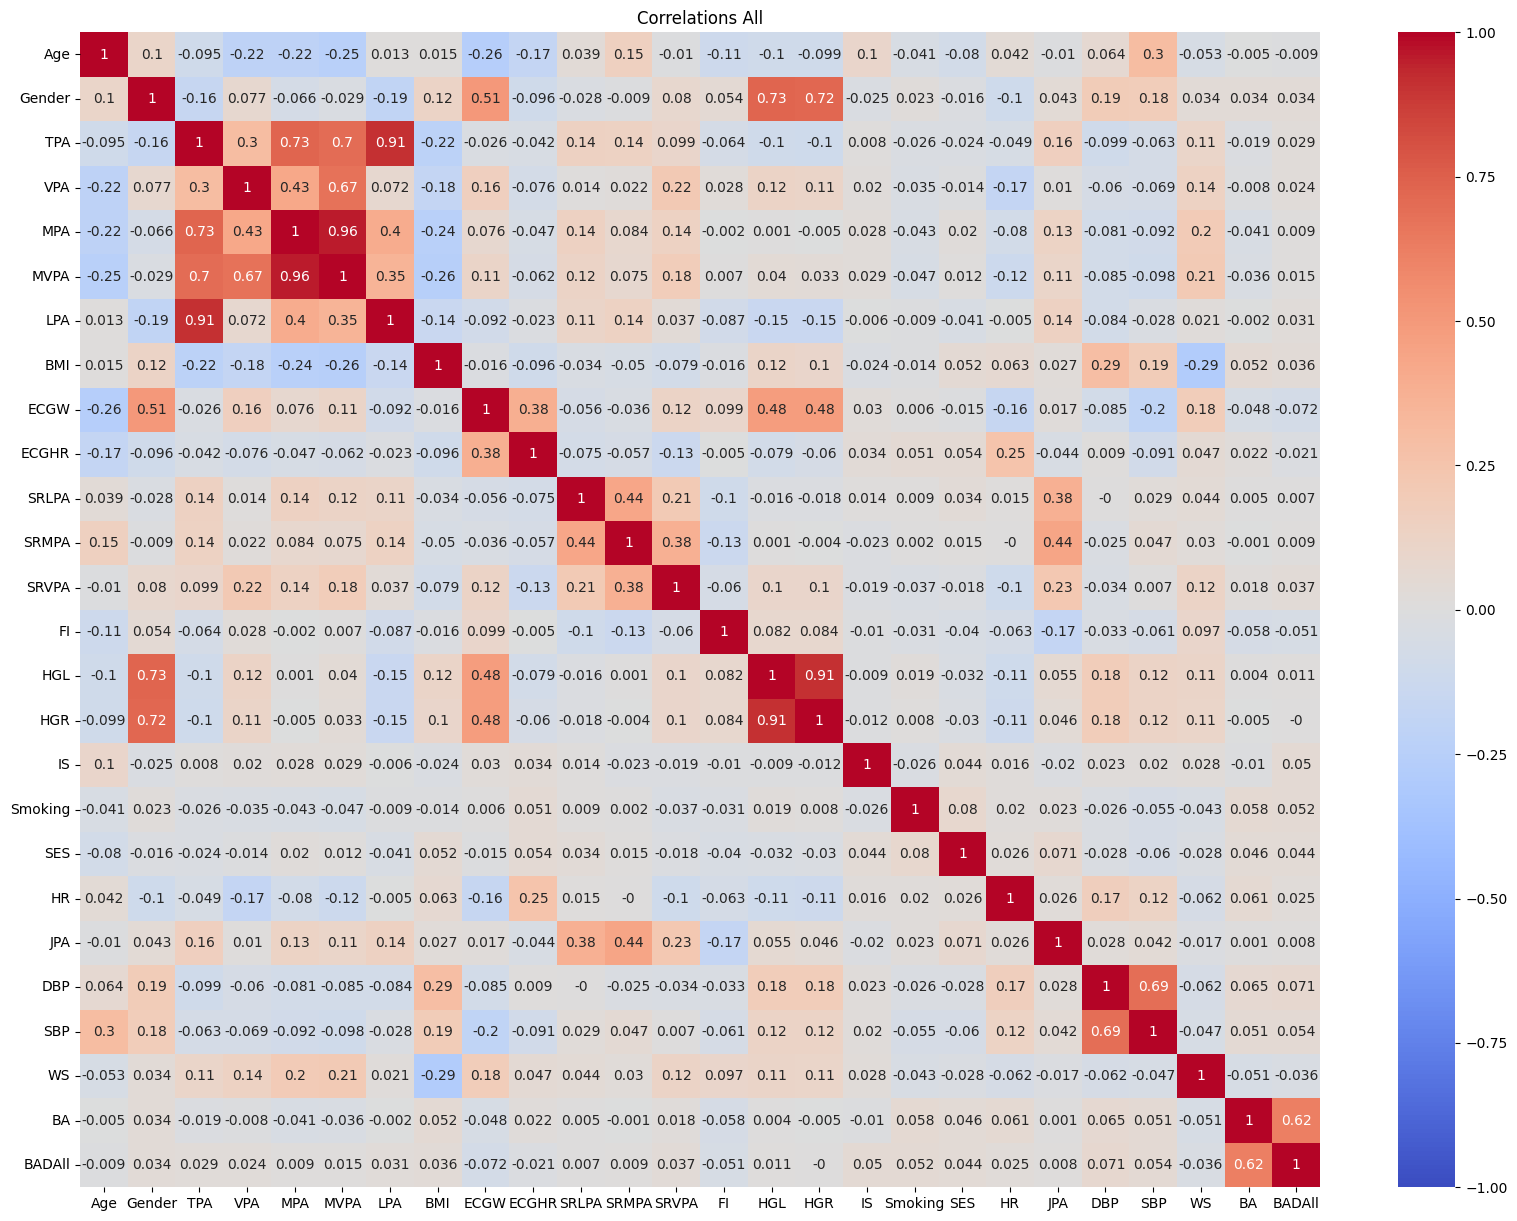

In [15]:
corr = main_test.corr()
corr = round(corr,3)
fig, ax = plt.subplots(figsize=(20,15)) 
sns.heatmap(corr, annot=True, cmap = "coolwarm", vmin=-1, vmax=1)
plt.title("Correlations All")

# 5 Partial Correlations with Covariates

# 6 Models with OLS

## 6.1 Covariates

In [16]:
cov_model = ols('BA ~ Gender + Age + IS + Gender:Age + Gender:IS + Age:IS', missing='drop', data = main_test).fit()
print(cov_model.summary())

                            OLS Regression Results                            
Dep. Variable:                     BA   R-squared:                       0.003
Model:                            OLS   Adj. R-squared:                  0.003
Method:                 Least Squares   F-statistic:                     4.625
Date:                Mon, 19 Dec 2022   Prob (F-statistic):           0.000106
Time:                        19:23:13   Log-Likelihood:                -28412.
No. Observations:                8386   AIC:                         5.684e+04
Df Residuals:                    8379   BIC:                         5.689e+04
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      4.5910      1.577      2.912      0.0

## Covariates + PA

In [17]:
pa_model = ols('BA ~ LPA + MPA + VPA + Gender + Age + IS + Gender:Age + Gender:IS + Age:IS', missing='drop', data = main_test).fit()
print(pa_model.summary())

                            OLS Regression Results                            
Dep. Variable:                     BA   R-squared:                       0.006
Model:                            OLS   Adj. R-squared:                  0.004
Method:                 Least Squares   F-statistic:                     5.192
Date:                Mon, 19 Dec 2022   Prob (F-statistic):           4.62e-07
Time:                        19:23:13   Log-Likelihood:                -28403.
No. Observations:                8386   AIC:                         5.683e+04
Df Residuals:                    8376   BIC:                         5.690e+04
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      5.0513      1.632      3.095      0.0

## Covariates + PA + Self-report PA

In [18]:
sr_pa_model = ols('BA ~ SRLPA + SRMPA + SRVPA +LPA + MPA + VPA+ Gender + Age + IS + Gender:Age + Gender:IS + Age:IS', missing='drop', data = main_test).fit()
print(sr_pa_model.summary())

                            OLS Regression Results                            
Dep. Variable:                     BA   R-squared:                       0.007
Model:                            OLS   Adj. R-squared:                  0.005
Method:                 Least Squares   F-statistic:                     3.916
Date:                Mon, 19 Dec 2022   Prob (F-statistic):           4.90e-06
Time:                        19:23:13   Log-Likelihood:                -24265.
No. Observations:                7171   AIC:                         4.856e+04
Df Residuals:                    7158   BIC:                         4.865e+04
Df Model:                          12                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      5.4788      1.764      3.106      0.0

## Covariates + Self-report PA

In [19]:
sr_model = ols('BA ~ SRLPA + SRMPA + SRVPA +Gender + Age + IS + Gender:Age + Gender:IS + Age:IS', missing='drop', data = main_test).fit()
print(sr_model.summary())

                            OLS Regression Results                            
Dep. Variable:                     BA   R-squared:                       0.004
Model:                            OLS   Adj. R-squared:                  0.002
Method:                 Least Squares   F-statistic:                     2.828
Date:                Mon, 19 Dec 2022   Prob (F-statistic):            0.00254
Time:                        19:23:13   Log-Likelihood:                -24276.
No. Observations:                7171   AIC:                         4.857e+04
Df Residuals:                    7161   BIC:                         4.864e+04
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      4.8106      1.706      2.819      0.0

# Comparing models

In [20]:
model_comparison = anova_lm(cov_model, pa_model)
print(model_comparison)

   df_resid            ssr  df_diff     ss_diff         F    Pr(>F)
0    8379.0  430409.992386      0.0         NaN       NaN       NaN
1    8376.0  429439.553237      3.0  970.439149  6.309307  0.000286


In [21]:
model_comparison = anova_lm(cov_model, sr_model)
print(model_comparison)

   df_resid            ssr  df_diff       ss_diff         F    Pr(>F)
0    8379.0  430409.992386      0.0           NaN       NaN       NaN
1    7161.0  366033.917253   1218.0  64376.075132  1.034021  0.218706


In [22]:
model_comparison = anova_lm(sr_model, sr_pa_model)
print(model_comparison)

   df_resid            ssr  df_diff      ss_diff         F    Pr(>F)
0    7161.0  366033.917253      0.0          NaN       NaN       NaN
1    7158.0  364939.124679      3.0  1094.792575  7.157838  0.000085


In [23]:
model_comparison = anova_lm(pa_model, sr_pa_model)
print(model_comparison)

   df_resid            ssr  df_diff       ss_diff         F    Pr(>F)
0    8376.0  429439.553237      0.0           NaN       NaN       NaN
1    7158.0  364939.124679   1218.0  64500.428558  1.038692  0.189374


# Health + Fitness 1

In [24]:
results = ols('BA ~ HGR + HR + DBP + Age + Gender + IS+ Gender:Age + Gender:IS + Age:IS', missing='drop', data = main_test).fit()
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:                     BA   R-squared:                       0.015
Model:                            OLS   Adj. R-squared:                  0.014
Method:                 Least Squares   F-statistic:                     11.47
Date:                Mon, 19 Dec 2022   Prob (F-statistic):           4.92e-18
Time:                        19:23:14   Log-Likelihood:                -22343.
No. Observations:                6617   AIC:                         4.471e+04
Df Residuals:                    6607   BIC:                         4.477e+04
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      3.3246      1.936      1.717      0.0

## Health + Fitness 2

## Health + Fitness 3

## Other variables (intelligences, SES)

## More interaction terms

# Model comparisons

# Mediation analysis

# Boxplots??